<a href="https://colab.research.google.com/github/dexEnjoyer/mini-project/blob/main/TelcoCustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import lime
import lime.lime_tabular

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b4316949bcd6b55552995012806570a7213b354f6a97373b2b076c587cb91fe7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
# Load dataset from file (Change path if needed)
file_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

In [4]:
# Show the first few rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

<ipython-input-5-32566c84c3fd>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [6]:
# Encode categorical variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
df = pd.get_dummies(df, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
                                 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies', 'Contract',
                                 'PaymentMethod'], drop_first=True)
df['Churn'] = LabelEncoder().fit_transform(df['Churn'])

In [7]:
# Split data
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [9]:
# Train models
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

Logistic Regression (Class Weighted)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



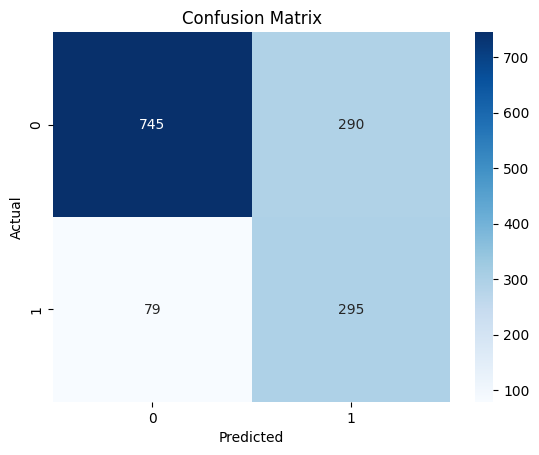

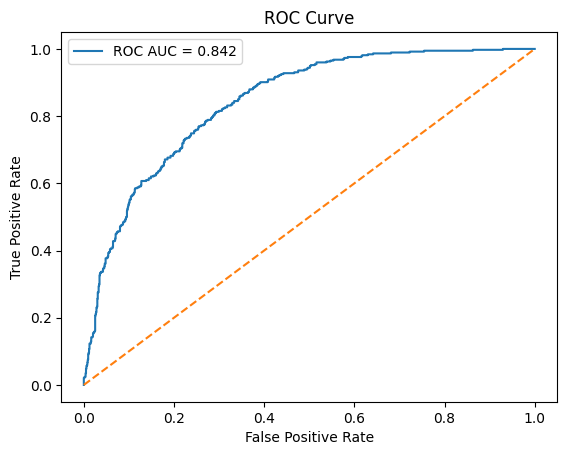

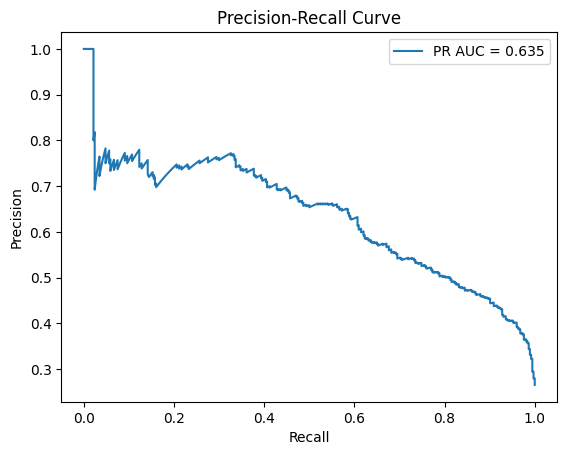

In [10]:
# Logistic Regression with Class Weights
lr = LogisticRegression(class_weight=class_weight_dict, max_iter=500)
print("Logistic Regression (Class Weighted)")
train_and_evaluate(lr, X_train, y_train, X_test, y_test)

Random Forest (SMOTE Oversampling)
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



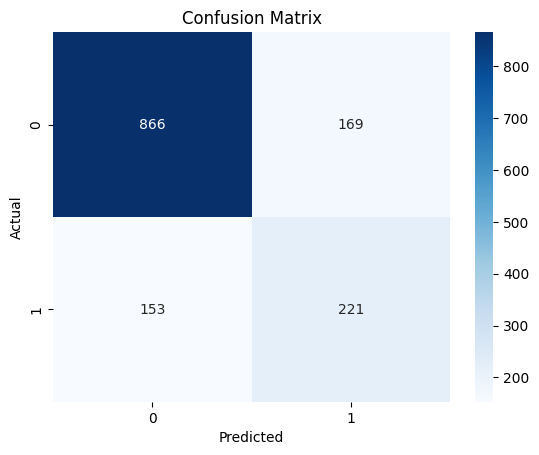

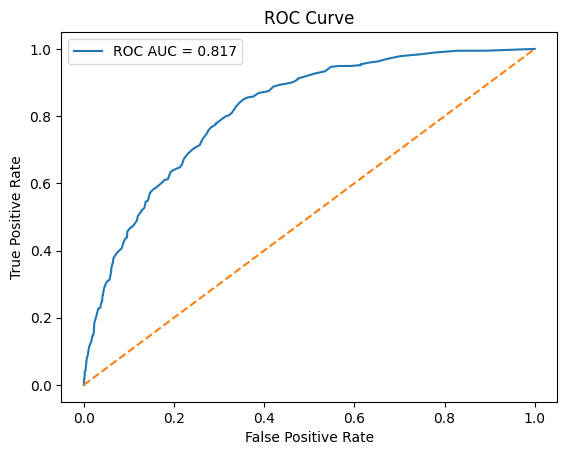

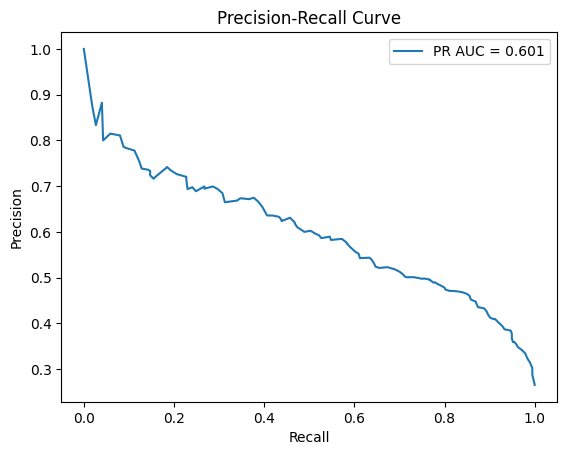

In [11]:
# Random Forest with SMOTE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Random Forest (SMOTE Oversampling)")
train_and_evaluate(rf, X_train_smote, y_train_smote, X_test, y_test)

XGBoost (Undersampling)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:15:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1035
           1       0.50      0.76      0.60       374

    accuracy                           0.73      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.79      0.73      0.75      1409



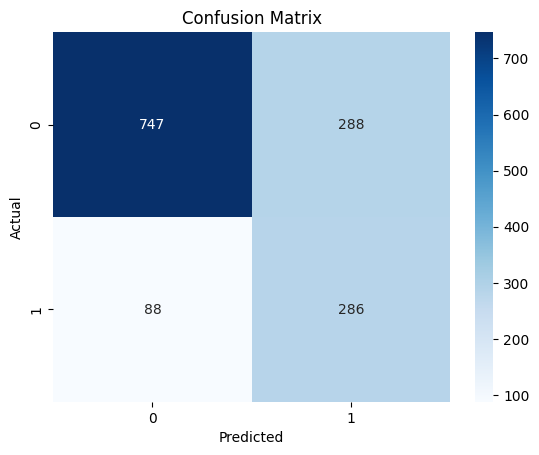

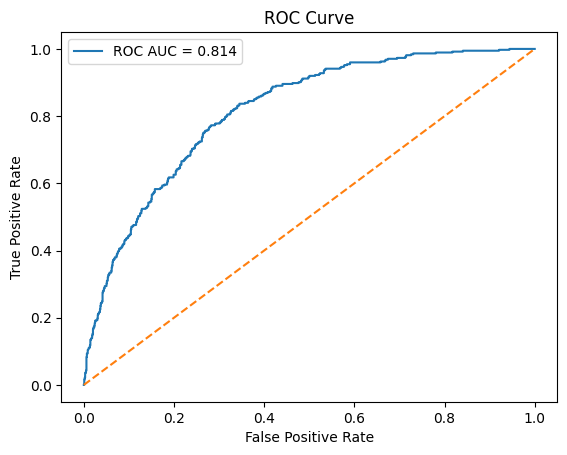

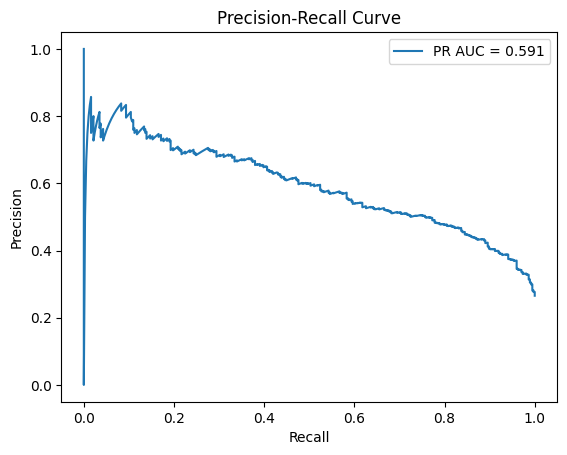

In [12]:
# XGBoost with Undersampling
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
print("XGBoost (Undersampling)")
train_and_evaluate(xgb, X_train_under, y_train_under, X_test, y_test)

In [15]:
# Explainability using LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_smote.values,
                                                   feature_names=X_train.columns.tolist(),
                                                   class_names=['No Churn', 'Churn'],
                                                   discretize_continuous=True)

idx = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.iloc[idx].values, rf.predict_proba, num_features=10)
exp.show_in_notebook()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
